## We will build a model of the house prices in the state of California.
The data includes metrics such as:
* Population  
* Median income
* Median housing price per block group (a geographical unit)

The goal of the model is to predict the median housing price in any district given these metrics

### Framing the problem
The output (i.e. the prediction of a district's median housing price) will be fed to another ML system, which in turn will determine if it's worth investing in the area. 

Currently, the prices are estimated manually by experts. In addition to the costs the manual estimates are often upwards of 30% off.

#### Solution outline
The task is a supervised learning task, as there are labeled examples that can train the output. 
As we are asked to predict a _single_ value based on several parameters it is a univariate multiple regression problem. 

Finally, the data is fixed and a relatively small volume so it can be done in memory and without consideration of new data. 

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import requests

def download_housing_data():
    '''
    Download dataset from Aurelien Gerons github. If the dataset exists it is not downloaded
    '''
    file_path = Path("datasets/housing.tgz")
    if not file_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as writer:
                writer.write(response.raw.read())
        with tarfile.open(file_path) as housing_tar:
            housing_tar.extractall(path="datasets")
#download_housing_data()


# Exploratory data analysis

In [3]:
# Load housing data
def reload_data():
    housing = pd.read_csv("datasets/housing/housing.csv")
    return housing
housing = reload_data()

In [4]:
# Read first couple of rows
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# Descriptive statistics
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<function matplotlib.pyplot.show(close=None, block=None)>

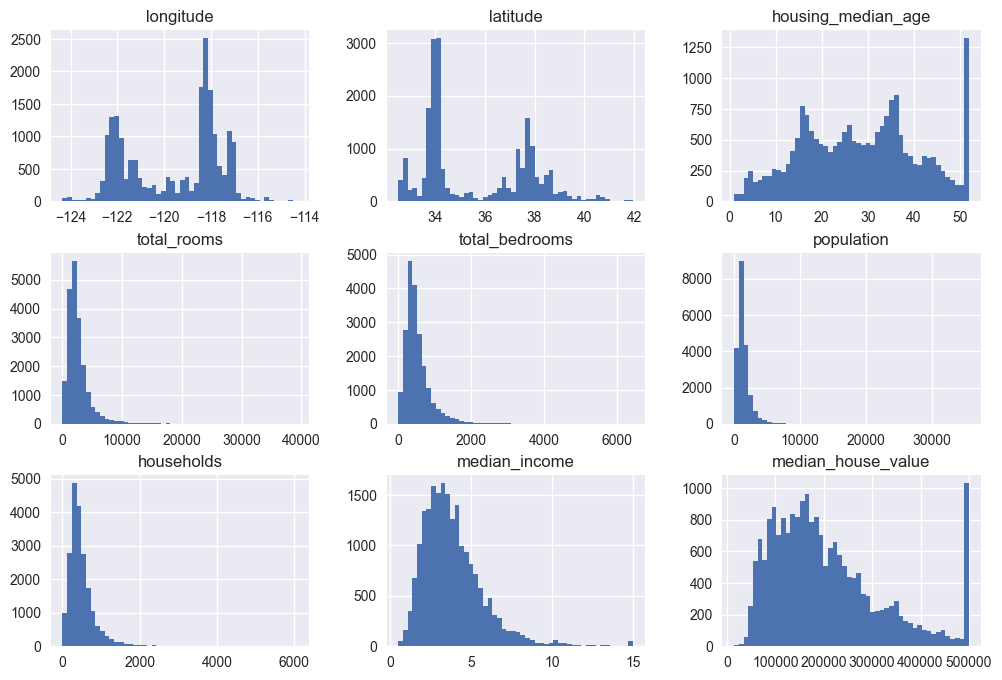

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

housing.hist(bins=50, figsize=(12,8))
plt.show

In [7]:
# Overkill
import seaborn as sns 
##sns.pairplot(housing)

* Median income is not expressed in USD, but is given in tens of thousands of dollars.  
* Housing median age and median house values are capped which could / can cause problems.
* Datasets are skewed right - this can cause some ML algorithms to fail at detecting patterns.  

### Splitting test and training data
Basically scikit learn can be used to test data but here are some manual implementations to get the hang of it:

In [8]:
# Create test set
import numpy as np

def shuffle_and_split_dat(data, test_ratio):
    '''
    This function will split data into a training dataset and a test dataset. 
    Every time the model runs (m) data will be regenerated, meaning the procedure slowly will go through the entire dataset.
    To avoid this np.random.seed(x) can be set, but this implementation will break the next time the dataset is updated.   
    '''
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

### Keeping state between runs
Keeping consistency between runs can be ensured is to use each instances identifier to decide whether or not it should go into the test set.

In [9]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
    '''
    
    '''
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    '''
    
    '''
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
# Usage of the above
housing_with_id = housing.reset_index() 
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state = 42) 

### Sampling methods
The previously used sampling methods have been purely random - which is fine with large datasets. If it isn't you risk introducing sampling bias. 
It is important to ensure that the training data is representative. This can be done by using stratified sampling - here the popoulation is divided into homogenous subgroups called strata.

Its important to have a sufficient number of instances in the dataset per stratum, else the estimate of the stratum's importance may be biased.

This means that each strata should be large enough and that there shouldnt be too many of them. 

<AxesSubplot:xlabel='median_income', ylabel='Count'>

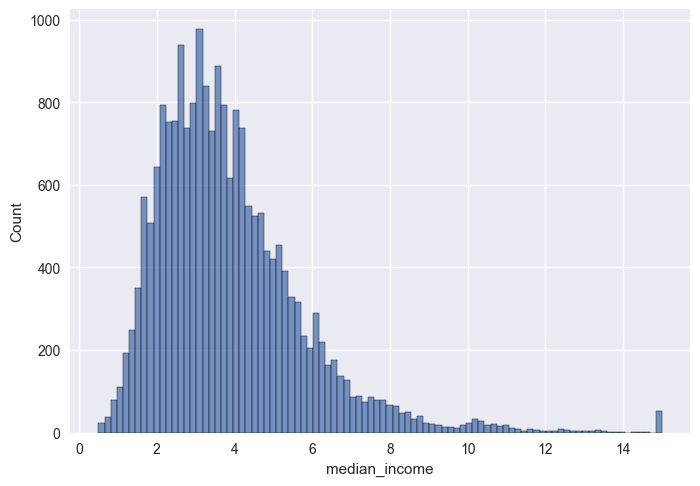

In [12]:
sns.histplot(data=housing['median_income'])

Looking at the histogram of median incomes from earlier it can be seen that most median incomes are centered around the 1.5 to 6 bracket. Some do go further though. Using the previous knowledge of strata we are going to create a new income strategy with just five categories.

<function matplotlib.pyplot.show(close=None, block=None)>

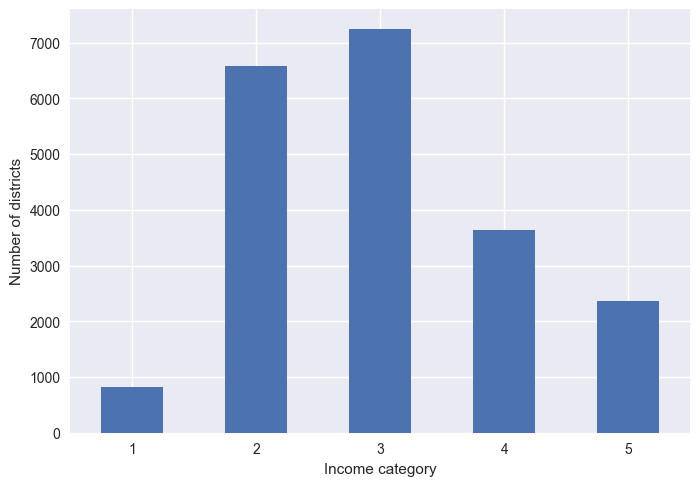

In [13]:
housing['income_cat'] = pd.cut(housing['median_income'],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show

We can now perform stratified sampling based on this new income category.
Several options are available in the sklearn.model_selection package. The methods split() return indices - not the data.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [15]:
strat_train_set, strat_test_set = strat_splits[0]

In [16]:
# Getting a single split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [17]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [18]:
# Dropping the income categories again
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
housing = strat_train_set.copy() 


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

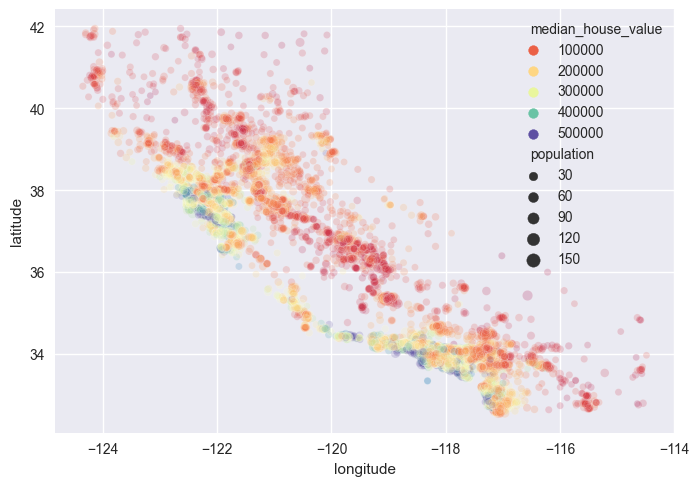

In [20]:
sns.scatterplot(housing, palette="Spectral", x="longitude",y="latitude",size=housing["population"]/100, hue="median_house_value", alpha=0.2)
#housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
#plt.show()

From this graph we can see that housing prices seem to be correlated with location and population density.

This can be checked out by calculating Pearson's R - the standard correlation coefficient - between every pair of attributes.

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Another way is by using the scatter_matrix() function in Pandas. This gives a plot per attribute giving $11^2$ plots.

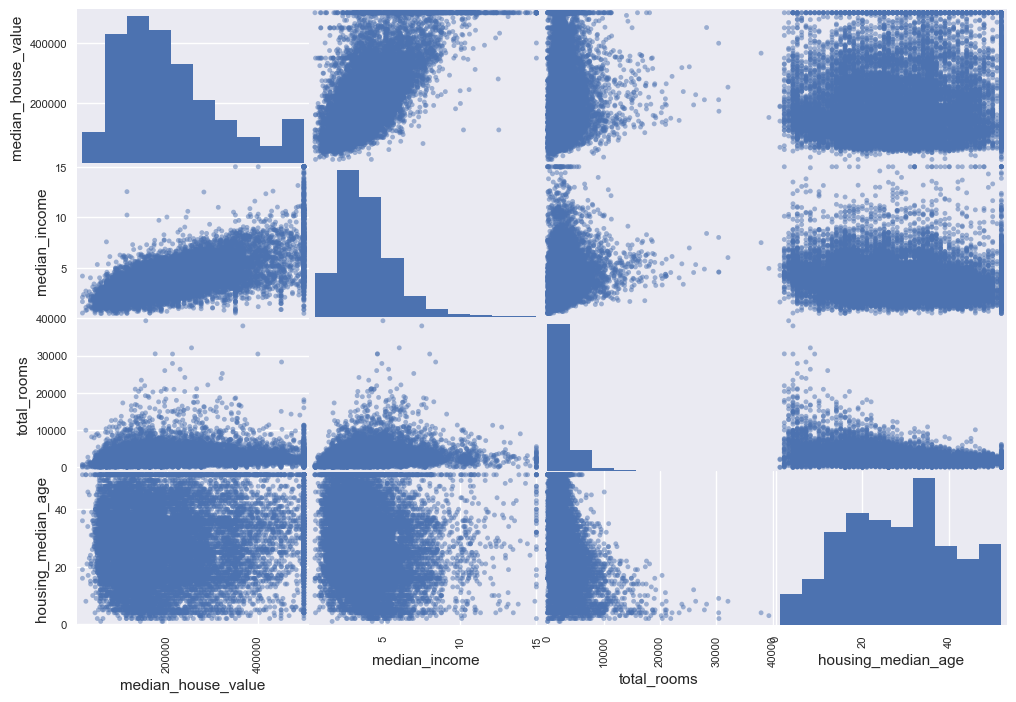

In [22]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
                "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

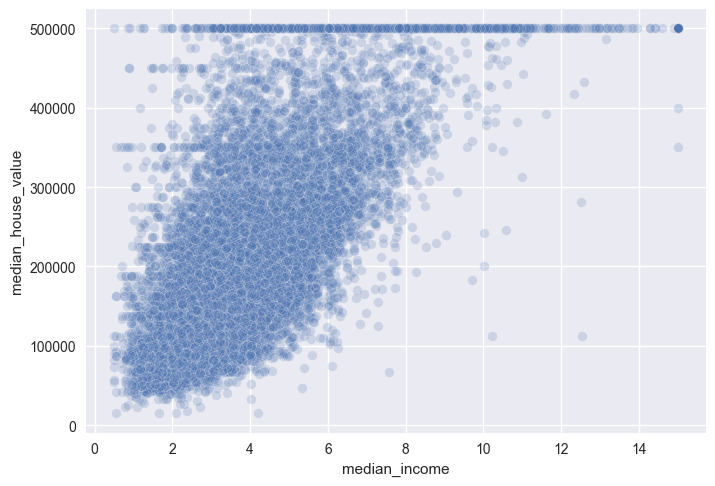

In [23]:
sns.scatterplot(housing, x="median_income", y="median_house_value", alpha=0.2)

There is a clear upward trend in the data without too much dispersion between the points. The price cap in the data is clearly visible towards the top of the plot. Additional lines are visible around 450k and 350k. 

In [24]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Machine Learning here we come 

In [26]:
# Initialize new training dataset
#def reset_data():
#    housing = strat_train_set.drop("median_house_value", axis=1)
#    housing_labels = strat_train_set['median_house_value'].copy()
#    return housing, housing_labels
#housing, housing_labels = reset_data() 

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


### Cleaning the data
Some attributes are missing - total_bedrooms for instance has some missing values. We can:
* Get rid of the corresponding districts
* Get rid of the whole attribute
* Set the missing values to some value (mean, median, zero, ...) - also known as imputation.

In [27]:
### DONT RUN THESE AS THEY BREAK THE DATASET

# Drop districts
#housing.dropna(subset=["total_bedrooms"], inplace=True)

# Drop attribute

#housing.drop("total_bedrooms",axis=1)

# Replace missing values
#median = housing['total_bedrooms'].median()
#housing['total_bedrooms'].fillna(median, inplace=True)

In [28]:
# Use sci-kits imputer to ease the task now and later
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # mean, most_frequent or constant can also be used

housing_num = housing.select_dtypes(include=[np.number])

In [29]:
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

This imputer which has been "trained" can now be used to transform the training set by replacing with learned medians: 

In [30]:
X = imputer.transform(housing_num)

In [31]:
# As all outputs from scikit-learn output NumPy arrays we have to wrap our X
# in a DataFrame to recover the column names

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_cat = housing[['ocean_proximity']]

In [32]:
# Transforming our categorical data into numbers
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)


In [33]:
# Creating dummy attributes instead
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [34]:
# Pandas alternative
df_test = pd.DataFrame({'ocean_proximity':["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [35]:
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

### Feature scaling and transformation
With many datasets it is necessary to perform feature scaling. When the range of different attributes differ significantly it is advisable to scale (or normalize) the data to similar ranges. Else the results might be biased - due to the nature of ML algorithms. 

Two common methods are min-max scaling or standardization.

In [36]:
# Scaling and transforming
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [37]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [38]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [39]:
# Transformations
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()

#housing = reload_data()
#housing, housing_labels = reset_data()

scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [40]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor= LinearRegression(), transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)


In [41]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [42]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [43]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

### Some custom transformers and how to build them

In [44]:
# Similar to StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args or **kwards
        self.with_mean = with_mean
        
    def fit(self, X, y=None): # y is required even though we don't use it
        X = check_array(X) # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self # always return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [45]:
# Custom Transformer that uses a KMeans clusterer in the fit() to find clusters in the training data
# and uses rbf_kernel() in transform() to measure how similar each sample is to each cluster center

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

### Pipelines
Sequencing a series of transformations can be done by using the scikit class Pipeline.

In [46]:
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn
sklearn.set_config(display="diagram")

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [47]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [48]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [49]:
# Adding the following from Aurelien Gerons official notebooks
# found at https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
# line 104

def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [50]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                            OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

housing_prepared = preprocessing.fit_transform(housing)

Now we'll create one single pipeline that performs the previously used transformations, doing the following:

* Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don’t expect missing values. In categorical features, missing values will be replaced by the most frequent category.

* The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs.

* A few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, and people_per_house. Hopefully these will better correlate with the median house value, and thereby help the ML models.

* A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.

* Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions.

* All numerical features will be standardized, as most ML algorithms prefer when all features have roughly the same scale.

In [52]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [53]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [54]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

### Time to select and train a model
We are going to train a basic linear regression model

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8EF8F7688>)])),
                ('linearregression', LinearRegression())])

In [56]:
# Running the model and seeing the predictions
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

The predictions are not very accurate so we would like to score the predictions by using the root mean square error. 

In [57]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68687.89176590017

The model is underfitting the training data. This means that the features do not provide enough information or the model isn't powerful enough. 

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8EF8F7688>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [59]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

Now there is no error. This is most likely due to overfitting of the data. To evaluate the model is by performing cross-validation.

This can be done by either using train_test_split() or the scikit k_-fold cross-validation feature.

This function works by randomly splitting the training set into a series of nonoverlapping subsets (folds) which it uses to train and evaluate a specific model that amount of times, picking a different fold for evaluation every time and using the other folds for training. 

In [60]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg,  housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

The results look very similar to what was found using the LinearRegression. The major problem with using cross-validation is that the model is trained several times, making it less feasible. 

In [61]:
lin_rmses = -cross_val_score(lin_reg,  housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

# Fine tuning models
## Grid Search
Instead of fiddling with hyperparameters it's possible to use GridSearchCV. This will cross-validate all combinations of hyperparameter values. 

In [64]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([("preprocessing", preprocessing),
                          ("random_forest", RandomForestRegressor(random_state=42)),])
param_grid = [{"preprocessing__geo__n_clusters": [5,8,10],
     "random_forest__max_features": [4,6,8]},
     {"preprocessing__geo__n_clusters": [10,15],
      "random_forest__max_features":[6,8,10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, 
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8EF8F7688>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [65]:
grid_search.best_params_
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001D...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8EFB76788>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [66]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,4.266667,0.080983,0.134125,0.004384,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43459.598047,-43918.632694,-44747.781772,-44042.004171,533.085183,1
13,5.223272,0.110550,0.128899,0.001491,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44132.027207,-44075.251239,-45009.672809,-44405.650418,427.736807,2
14,6.571348,0.115040,0.156002,0.004323,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44374.325167,-44285.549219,-45316.375999,-44658.750128,466.421934,3
7,4.114235,0.101218,0.149662,0.017632,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44683.355320,-44654.825561,-45657.384730,-44998.521871,466.031964,4
9,4.374277,0.025117,0.145013,0.008590,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44683.355320,-44654.825561,-45657.384730,-44998.521871,466.031964,4


If the hyperparameter search space is large it can be "better" to use RandomizedSearchCV.

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {"preprocessing__geo__n_clusters": randint(low=3, high=50),
                  "random_forest__max_features": randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42)

rnd_search.fit(housing,housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8EF8F7688>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D8EFB7A708>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D8EFE4CA48>},
                   random_state=42, scoring='neg_root_mean_squared_error')

## Ensemble methods
Fine-tuning can also be done by combining the models that perform the best. This ensemble model will often perform better than the best individual model.

In [69]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [70]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.013489636258229071, 'geo__Cluster 3 similarity'),
 (0.013383196263838682, 'geo__Cluster 38 similarit

Based on this it would be possible to drops some of the less useful features. It seems that only one ocean_proximity category is actually useful.

### Evaluate the system
Now it's time to evaluate the model that works the best. We refind our predictors and labels from the test set and we rerun our final model to transform and predict - and then evalute the results. 

In [71]:
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse= mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


In [72]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,loc=squared_errors.mean(),scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

Towards the end of this section Aurelien goes into how the job can be deployed. But I am currently skipping this part. 